## Initial Stenosis model comparision experiments
### Notes:
**For all models apart from YOLO I used the StenUNet (https://arxiv.org/pdf/2310.14961) preprocessing method, the StenUNet augmentations, and to compare the impact of StenUNet's post processing algorithm, I ran each model with and without post-processing.**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data = pd.read_csv("scores/sten_exp_scores.csv", index_col='Model')
pp_data

,Preprocessing,Augmentations,Postprocessing,Jaccard,F1,Recall,Precision,Acc,F2,HD,MFPS
Model,,,,,,,,,,,
ResUNet++,StenUNet,StenUNet,NaN,0.2516,0.3572,0.4339,0.3720,0.9851,0.3938,3.8237,168.528
ResUNet++ (PostProc),StenUNet,StenUNet,StenUNet,0.2519,0.3674,0.4334,0.3800,0.9851,0.3936,3.8279,NaN
DeepLabV3ResNet101,StenUNet,StenUNet,NaN,0.4335,0.5758,0.6052,0.6404,0.9920,0.5824,3.5716,96.739
DeepLabV3ResNet101 (PostProc),StenUNet,StenUNet,StenUNet,0.4337,0.5759,0.6049,0.6458,0.9921,0.5822,3.5748,NaN
Attention UNet,StenUNet,StenUNet,NaN,0.4213,0.5617,0.6338,0.5877,0.9912,0.5903,3.4762,233.800
Attention UNet (PostProc),StenUNet,StenUNet,StenUNet,0.4218,0.5616,0.6329,0.5917,0.9913,0.5898,3.4793,NaN
YOLOv8x-seg,StenUNet,YOLO,NaN,0.3234,0.4244,0.4315,0.7354,0.9914,0.4205,4.0100,44.643
YOLOv8x-seg (PostProc),StenUNet,YOLO,StenUNet,0.3163,0.4183,0.4124,0.7452,0.9915,0.4075,3.9999,NaN
TransUNet,StenUNet,StenUNet,NaN,0.0433,0.0741,0.1014,0.5846,0.9839,0.0827,4.5840,140.153


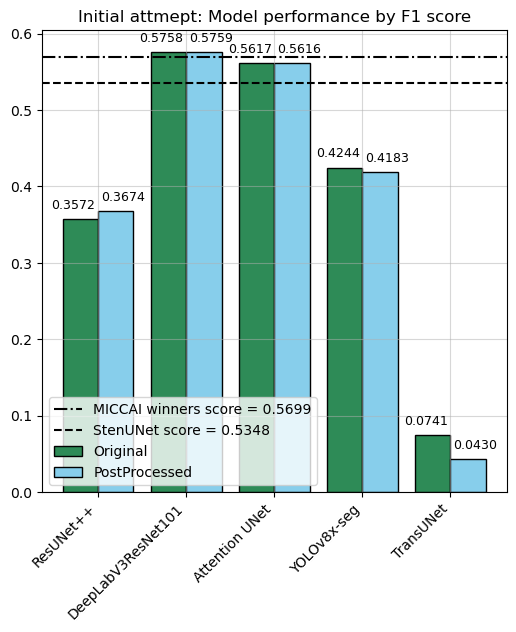

In [155]:
fig, ax = plt.subplots(figsize=(6,6))
x = np.arange(len(data) // 2)
width = 0.4

ax.bar(x - width/2, data['F1'][::2], width, edgecolor='black', color='seagreen', label='Original')
ax.bar(x + width/2, data['F1'][1::2], width, edgecolor='black', color='skyblue', label='PostProcessed')

for i, (v1, v2) in enumerate(zip(data['F1'][::2], data['F1'][1::2])):
    ax.text(i - 0.28, v1+0.01, f"{v1:.4f}", ha='center', va='bottom', fontsize=9)
    ax.text(i + 0.28, v2+0.01, f"{v2:.4f}", ha='center', va='bottom', fontsize=9)

ax.set_xticks(x)
ax.set_xticklabels(data.index[::2], rotation=45, ha='right')

ax.axhline(0.5699, color='black', linestyle='dashdot', label='MICCAI winners score = 0.5699')
ax.axhline(0.5348, color='black', linestyle='dashed', label='StenUNet score = 0.5348')

ax.grid(alpha=0.5)
ax.set(title='Initial attmept: Model performance by F1 score')
plt.legend(loc='lower left')
plt.show()

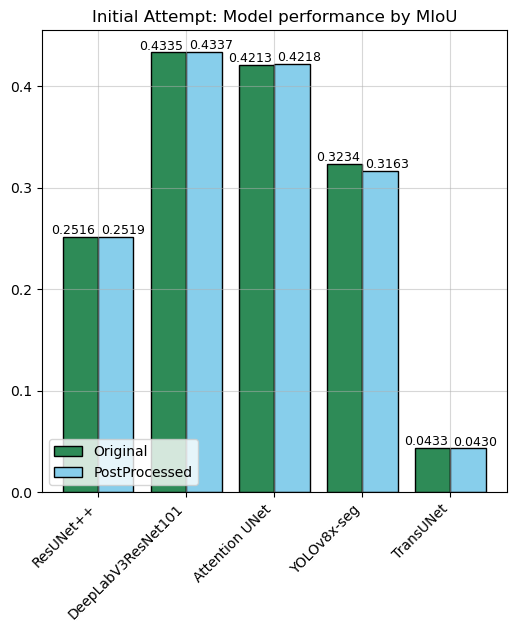

In [156]:
fig, ax = plt.subplots(figsize=(6,6))
x = np.arange(len(data) // 2)
width = 0.4

ax.bar(x - width/2, data['Jaccard'][::2], width, edgecolor='black', color='seagreen', label='Original')
ax.bar(x + width/2, data['Jaccard'][1::2], width, edgecolor='black', color='skyblue', label='PostProcessed')

for i, (v1, v2) in enumerate(zip(data['Jaccard'][::2], data['Jaccard'][1::2])):
    ax.text(i - 0.28, v1 , f"{v1:.4f}", ha='center', va='bottom', fontsize=9)
    ax.text(i + 0.28, v2 , f"{v2:.4f}", ha='center', va='bottom', fontsize=9)

ax.set_xticks(x)
ax.set_xticklabels(data.index[::2], rotation=45, ha='right')
ax.grid(alpha=0.5)
ax.set(title='Initial Attempt: Model performance by MIoU')
plt.legend(loc='lower left')
plt.show()

## Comments
- StenUnet's post processing algorithm only improved results for ResUNet++. It actually reduced the scores for YOLOv8 and TransUNet. This may or may not be due to the threshold chosen
- TransUNet underperformed. I think this is due to the model oversegmenting, and getting distracted by the entire vessel overall rather than just the area of stenosis.
- DeepLabV3ResNet101 (in built torch model) actually managed to **just** beat the MICCAI winners by 0.007
- AttentionUNet beat the StenUNet score but not the MICCAI winners.

## Next steps
- Quick experiment with post processing threshold
- Experiment with different optimisers? They all used Adam, apart from YOLO which I left as auto and transunet as sgd
- Add my own block to one of the models to try and improve - maybe add a residual block/s to Attention UNet

# Threshold study found that the original threshold (50) was appropriate:

In [152]:
pp_data = pd.read_csv('scores/pp_scores.csv')
pp_data = pp_data.drop([2,4,6,8,10])
pp_data.at[0,'Threshold'] = 'thresh_0'
pp_data

,Model,Threshold,Jaccard,F1,Recall,Precision,Acc,F2,HD,MFPS,MSPF
0,attentionunet,thresh_0,0.4214,0.5618,0.6339,0.5879,0.9912,0.5904,3.4743,497.386047,0.000007
1,attentionunet,thresh_25,0.4217,0.5618,0.6334,0.5918,0.9912,0.5901,3.4770,497.386047,0.000007
3,attentionunet,thresh_50,0.4221,0.5620,0.6331,0.5930,0.9913,0.5901,3.4774,615.190917,0.000005
5,attentionunet,thresh_75,0.4220,0.5615,0.6323,0.5922,0.9913,0.5894,3.4830,611.956655,0.000005
7,attentionunet,thresh_100,0.4220,0.5612,0.6317,0.5960,0.9913,0.5890,3.4845,601.562457,0.000006
9,attentionunet,thresh_125,0.4219,0.5607,0.6306,0.5963,0.9913,0.5882,3.4895,582.899788,0.000006
11,attentionunet,thresh_150,0.4211,0.5594,0.6294,0.5959,0.9913,0.5870,3.4971,575.370864,0.000006


/tmp/ipykernel_7895/1408403060.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(pp_data['Threshold'], rotation=45, ha='right')


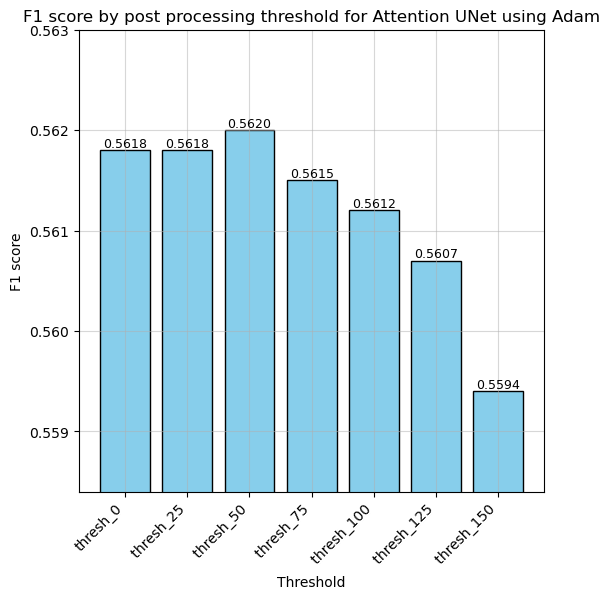

In [171]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,6))

ax.bar(pp_data['Threshold'], pp_data['F1'], color='skyblue', edgecolor='black')

for i, v in enumerate(pp_data['F1']):
    ax.text(i, v, f"{v:.4f}", ha='center', va='bottom', fontsize=9)

ax.grid(alpha=0.5)
ax.set(title='F1 score by post processing threshold for Attention UNet using Adam', xlabel='Threshold', ylabel='F1 score')
ax.set_xticklabels(pp_data['Threshold'], rotation=45, ha='right')
plt.ylim(min(pp_data['F1'])-0.001, max(pp_data['F1'])+0.001)
plt.show()

# Conducted Optimiser Experiment for the top three performing models above:

In [94]:
opt_data = pd.read_csv('scores/optimiser_scores.csv', index_col='Model')
opt_data.index = [
    f"{label} (PostProc)" if i % 2 == 1 else label
    for i, label in enumerate(opt_data.index)]
opt_data

,Optimiser,Jaccard,F1,Recall,Precision,Acc,F2,HD,MFPS,MSPF
deeplabv3resnet101,RMSprop,0.4361,0.5795,0.6535,0.6015,0.9915,0.6087,3.4558,241.859821,0.000014
deeplabv3resnet101 (PostProc),RMSprop,0.4364,0.5797,0.6532,0.6022,0.9915,0.6087,3.4569,241.859821,0.000014
deeplabv3resnet101,adam,0.4335,0.5758,0.6053,0.6402,0.9920,0.5824,3.5714,234.683708,0.000014
deeplabv3resnet101 (PostProc),adam,0.4337,0.5758,0.6050,0.6457,0.9921,0.5823,3.5750,234.683708,0.000014
deeplabv3resnet101,SGD,0.3401,0.4735,0.5984,0.4890,0.9886,0.5255,3.7720,245.597627,0.000014
deeplabv3resnet101 (PostProc),SGD,0.3399,0.4730,0.5977,0.4953,0.9886,0.5250,3.7743,245.597627,0.000014
attentionunet,RMSprop,0.3864,0.5269,0.5925,0.5548,0.9906,0.5527,3.5288,472.811087,0.000007
attentionunet (PostProc),RMSprop,0.3873,0.5276,0.5919,0.5583,0.9907,0.5528,3.5322,472.811087,0.000007
attentionunet,adam,0.4214,0.5618,0.6339,0.5879,0.9912,0.5904,3.4743,498.900611,0.000007
attentionunet (PostProc),adam,0.4221,0.5620,0.6331,0.5930,0.9913,0.5901,3.4774,498.900611,0.000007


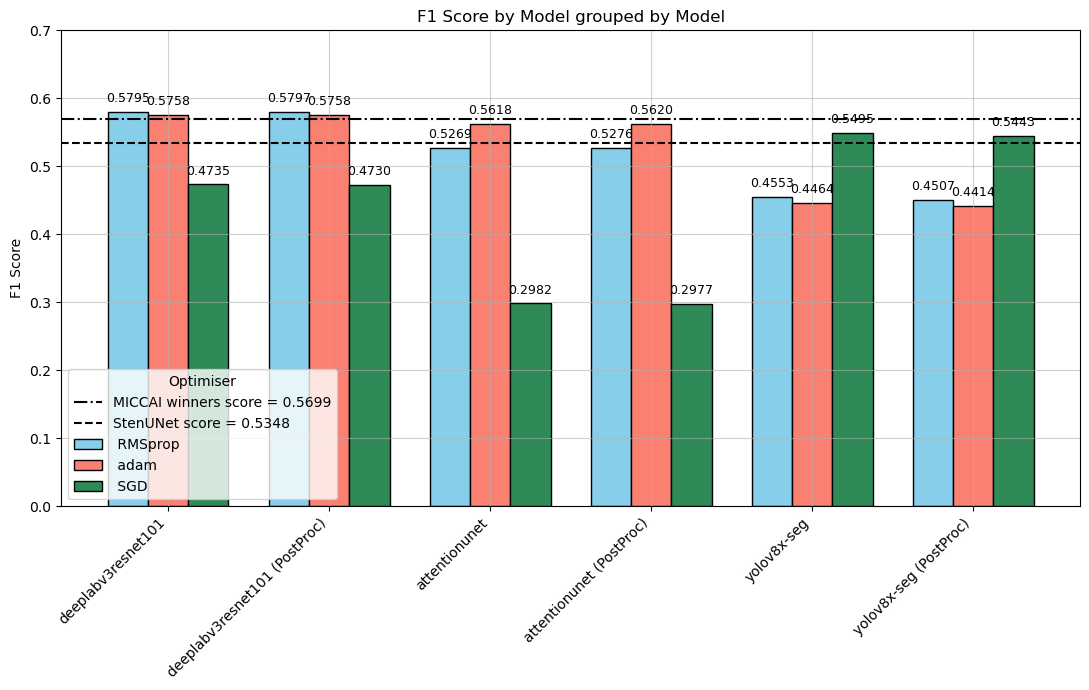

In [170]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


models = opt_data.index.unique()
optimisers = opt_data['Optimiser'].unique()
colors = {optimisers[0]: 'skyblue', optimisers[1]: 'salmon', optimisers[2]: 'seagreen'}


# Prepare plot
bar_width = 0.15
x = np.arange(len(models))

fig, ax = plt.subplots(figsize=(11,7))

for i, opt in enumerate(optimisers):

    f1_scores = []
    for model in models:
        vals = opt_data[(opt_data.index == model) & (opt_data['Optimiser'] == opt)]['F1'].values
        f1_scores.append(vals[0])

    # Shift bars for each optimiser in a group
    positions = x*0.6 + i*bar_width - bar_width
    bars = plt.bar(positions, f1_scores, width=bar_width, color=colors[opt], label=opt, edgecolor='black')

    # Add numbers on top
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.4f}', ha='center', va='bottom', fontsize=9)

ax.axhline(y=0.5699, color='black', linestyle='dashdot', label='MICCAI winners score = 0.5699')
ax.axhline(y=0.5348, color='black', linestyle='dashed', label='StenUNet score = 0.5348')

ax.grid(alpha=0.6)
plt.xticks(x*0.6, models, rotation=45, ha='right')
plt.ylabel('F1 Score')
plt.title('F1 Score by Model grouped by Model')
plt.legend(title='Optimiser')
plt.ylim(0, 0.7)
plt.tight_layout()
plt.show()


## Comments: Best optimisers for top three models
 - DLV3RN101 (PostProc) = **RMSprop** @ 0.5797
 - AUN (PostProc) = **Adam** @ 0.5620
 - Yolo = **SGD** @ 0.5495

# Modifications to Attention Unet
- Attention UNet: UNet with attention gates
- AUNET1: Add deformable convolutions to encoder blocks (in the hopes it would pick up abstract stenosis better)
- AUNET2: Add ASPP bridge (better long range dependancies, inspired by DLV3RN101 and ResUNet++)
- AUNET3 Added residual bottlenecks in place of encoder convolutions onto AUNET2 (inspired by DLV3RN101)

In [106]:
mod_data = pd.read_csv('scores/mod_scores.csv', index_col='Model')
mod_data.index = [
    f"{label} (PostProc)" if i % 2 == 1 else label
    for i, label in enumerate(mod_data.index)]
mod_data

,Jaccard,F1,Recall,Precision,Acc,F2,HD,MFPS,MSPF
attentionunet,0.4214,0.5618,0.6339,0.5879,0.9912,0.5904,3.4743,498.900611,0.000007
attentionunet (PostProc),0.4221,0.5620,0.6331,0.5930,0.9913,0.5901,3.4774,498.900611,0.000007
aunet1,0.4007,0.5408,0.5966,0.6047,0.9912,0.5619,3.5407,254.219656,0.000013
aunet1 (PostProc),0.4012,0.5409,0.5957,0.6119,0.9912,0.5614,3.5543,254.219656,0.000013
aunet2,0.4226,0.5667,0.6328,0.5922,0.9914,0.5923,3.4909,398.254542,0.000008
aunet2 (PostProc),0.4231,0.5671,0.6325,0.5969,0.9914,0.5923,3.4917,398.254542,0.000008
aunet3,0.3911,0.5301,0.5847,0.5707,0.9910,0.5498,3.5947,342.394213,0.000010
aunet3 (PostProc),0.3921,0.5308,0.5840,0.5767,0.9911,0.5498,3.6013,342.394213,0.000010


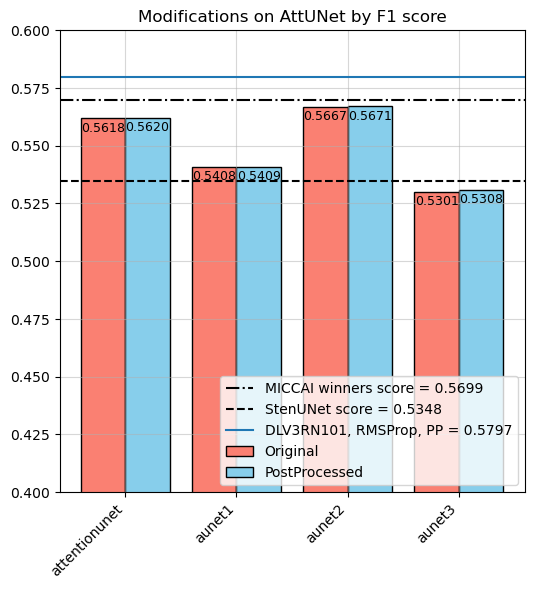

In [169]:
import numpy as np

fig, ax = plt.subplots(figsize=(6,6))
x = np.arange(len(mod_data) // 2)
width = 0.4

ax.bar(x - width/2, mod_data['F1'][::2], width, edgecolor='black', color='salmon', label='Original')
ax.bar(x + width/2, mod_data['F1'][1::2], width, edgecolor='black', color='skyblue', label='PostProcessed')

for i, (v1, v2) in enumerate(zip(mod_data['F1'][::2], mod_data['F1'][1::2])):
    ax.text(i - width/2, v1 - 0.007, f"{v1:.4f}", ha='center', va='bottom', fontsize=9)
    ax.text(i + width/2, v2 - 0.007, f"{v2:.4f}", ha='center', va='bottom', fontsize=9)

ax.set_xticks(x)
ax.set_xticklabels(mod_data.index[::2], rotation=45, ha='right')

ax.axhline(0.5699, color='black', linestyle='dashdot', label='MICCAI winners score = 0.5699')
ax.axhline(0.5348, color='black', linestyle='dashed', label='StenUNet score = 0.5348')
ax.axhline(0.5797, label='DLV3RN101, RMSProp, PP = 0.5797')

ax.grid(alpha=0.5)
ax.set(title='Modifications on AttUNet by F1 score')
plt.ylim(0.4, 0.6)
plt.legend(loc='lower right')
plt.show()

# Comments

In [29]:
import torchvision
import torch
from torch import nn
from torchinfo import summary

model = torchvision.models.segmentation.deeplabv3_resnet101(weights='DEFAULT', progress=True, aux_loss=None)
model.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)

summary(model, (1,3,256,256))

Layer (type:depth-idx)                             Output Shape              Param #
DeepLabV3                                          [1, 21, 256, 256]         --
├─IntermediateLayerGetter: 1-1                     [1, 2048, 32, 32]         --
│    └─Conv2d: 2-1                                 [1, 64, 128, 128]         9,408
│    └─BatchNorm2d: 2-2                            [1, 64, 128, 128]         128
│    └─ReLU: 2-3                                   [1, 64, 128, 128]         --
│    └─MaxPool2d: 2-4                              [1, 64, 64, 64]           --
│    └─Sequential: 2-5                             [1, 256, 64, 64]          --
│    │    └─Bottleneck: 3-1                        [1, 256, 64, 64]          75,008
│    │    └─Bottleneck: 3-2                        [1, 256, 64, 64]          70,400
│    │    └─Bottleneck: 3-3                        [1, 256, 64, 64]          70,400
│    └─Sequential: 2-6                             [1, 512, 32, 32]          --
│    │    └─Bottlen